In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [8]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Hello! How may I help you?",name="LLM")]
messages.append(HumanMessage(content=f"I want to cook and omlette",name="Jyo"))
messages.append(AIMessage(content=f"What ingredients do you have?",name="LLM"))
messages.append(HumanMessage(content=f"I have eggs, oil, salt and ice cream",name="Jyo"))


for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hello! How may I help you?
================================ Human Message =================================
Name: Jyo

I want to cook and omlette
================================== Ai Message ==================================
Name: LLM

What ingredients do you have?
================================ Human Message =================================
Name: Jyo

I have eggs, oil, salt and ice cream


### Chat Models

In [10]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="Gemma2-9b-It")
result=llm.invoke(messages)

In [11]:
result.response_metadata

{'token_usage': {'completion_tokens': 313,
  'prompt_tokens': 60,
  'total_tokens': 373,
  'completion_time': 0.569090909,
  'prompt_time': 0.001786598,
  'queue_time': 0.253384601,
  'total_time': 0.570877507},
 'model_name': 'Gemma2-9b-It',
 'system_fingerprint': 'fp_10c08bf97d',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

In [1]:
def add(a:int,b:int) -> int:
    """Add a and b
    Args:
        a (int): The first int
        b (int): The second int
    
        Returns:
        int
    """
    
    return a + b

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="Gemma2-9b-It")

In [4]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10624e660>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10624f230>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
llm_with_tools=llm.bind_tools([add])

toolcall=llm_with_tools.invoke([HumanMessage(content=f"what is 69 plus 420?",name="Jyo")])

In [11]:
toolcall.tool_calls

[{'name': 'add',
  'args': {'a': 69, 'b': 420},
  'id': '0h1w3z7b0',
  'type': 'tool_call'}]

### Using messages as state

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

In [13]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [14]:
initial_messages = [AIMessage(content=f"Hello! How may I help you?",name="LLM")]
initial_messages.append(HumanMessage(content=f"I want to cook and omlette",name="Jyo"))
initial_messages.append(AIMessage(content=f"What ingredients do you have?",name="LLM"))
initial_messages.append(HumanMessage(content=f"I have eggs, oil, salt and ice cream",name="Jyo"))
initial_messages

[AIMessage(content='Hello! How may I help you?', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='I want to cook and omlette', additional_kwargs={}, response_metadata={}, name='Jyo'),
 AIMessage(content='What ingredients do you have?', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='I have eggs, oil, salt and ice cream', additional_kwargs={}, response_metadata={}, name='Jyo')]

In [15]:
ai_message=AIMessage(content=f"Don't add ice cream in the recipe!",name="LLM")
ai_message

AIMessage(content="Don't add ice cream in the recipe!", additional_kwargs={}, response_metadata={}, name='LLM')

In [16]:
add_messages(initial_messages,ai_message)

[AIMessage(content='Hello! How may I help you?', additional_kwargs={}, response_metadata={}, name='LLM', id='a42c8e7b-477c-48e4-98c2-3a5ab4ac5446'),
 HumanMessage(content='I want to cook and omlette', additional_kwargs={}, response_metadata={}, name='Jyo', id='f95e5635-db84-4ed4-af80-332fea433abf'),
 AIMessage(content='What ingredients do you have?', additional_kwargs={}, response_metadata={}, name='LLM', id='c028a681-3da5-4980-81c0-3e8411e56bb0'),
 HumanMessage(content='I have eggs, oil, salt and ice cream', additional_kwargs={}, response_metadata={}, name='Jyo', id='cb2e0d8f-e4ef-4897-a48a-a397e58e3453'),
 AIMessage(content="Don't add ice cream in the recipe!", additional_kwargs={}, response_metadata={}, name='LLM', id='05948b82-27cb-4ca8-9101-962a7e9419c4')]

In [17]:
def llm_tools(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

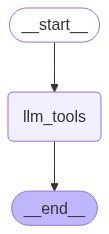

In [18]:
from IPython.display import display, Image
from langgraph.graph import StateGraph,START,END

builder=StateGraph(State)

builder.add_node("llm_tools",llm_tools)

builder.add_edge(START,"llm_tools")
builder.add_edge("llm_tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages= graph.invoke({"messages":"What is 69 plus 420?"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 69 plus 420?
================================== Ai Message ==================================
Tool Calls:
  add (6cgrnwnk1)
 Call ID: 6cgrnwnk1
  Args:
    a: 69
    b: 420


In [23]:
tools=[add]

In [26]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("llm_tools", llm_tools)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_tools")
builder.add_conditional_edges(
    "llm_tools",
    tools_condition
)
builder.add_edge("tools",END)

graph_builder=builder.compile()


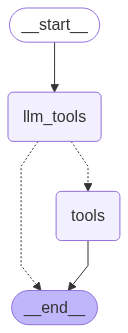

In [28]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [29]:
messages= graph_builder.invoke({"messages":"What is 69 plus 420?"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 69 plus 420?
================================== Ai Message ==================================
Tool Calls:
  add (f7faj33qx)
 Call ID: f7faj33qx
  Args:
    a: 69
    b: 420
================================= Tool Message =================================
Name: add

489


In [32]:
messages= graph_builder.invoke({"messages":"What is Machine Learning?"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  add (2mn8atcy4)
 Call ID: 2mn8atcy4
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5


# IDK Why this happened?